In [1]:
import river
import pandas as pd

In [2]:
data_path = "../data/resource_events3.csv"
df = pd.read_csv(data_path)

print("Dataset shape:", df.shape)
print("Columns:", df.columns.tolist())

Dataset shape: (17808, 25)
Columns: ['pid', 'comm', 'uid', 'gid', 'ppid', 'user_pid', 'user_ppid', 'cgroup_id', 'cgroup_name', 'user', 'cpu_ns', 'user_faults', 'kernel_faults', 'vm_mmap_bytes', 'vm_munmap_bytes', 'vm_brk_grow_bytes', 'vm_brk_shrink_bytes', 'bytes_written', 'bytes_read', 'isActive', 'wall_time_dt', 'wall_time_ms', 'container_id', 'container_image', 'container_labels_json']


In [3]:
feature_cols = [
    "cpu_ns",
    "user_faults",
    "kernel_faults",
    "vm_mmap_bytes",
    "vm_munmap_bytes",
    "vm_brk_grow_bytes",
    "vm_brk_shrink_bytes",
    "bytes_written",
    "bytes_read"
]

context_cols = [
    "pid",
    "comm",
    "user",
    "container_id",
    "container_image",
    "wall_time_ms"
]

In [4]:
X = df[feature_cols].copy()
context = df[context_cols].copy()

print("\nFeature matrix sample:")
display(X.head())

print("\nContext sample:")
display(context.head())


Feature matrix sample:


,cpu_ns,user_faults,kernel_faults,vm_mmap_bytes,vm_munmap_bytes,vm_brk_grow_bytes,vm_brk_shrink_bytes,bytes_written,bytes_read
0,0,0,0,0,0,0,0,0,0
1,8463460,32,0,0,0,0,0,34858,143815
2,438120,9,0,0,0,0,0,538,2712
3,325145,0,0,0,0,0,0,1601,1601
4,263360,16,0,0,0,0,0,588,2860



Context sample:


,pid,comm,user,container_id,container_image,wall_time_ms
0,261,weston,aleyi,NaN,NaN,1757706413333
1,3100,dockerd,root,NaN,NaN,1757706413333
2,3873,containerd-shim,root,NaN,NaN,1757706413333
3,2174,Relay(1847),root,NaN,NaN,1757706413333
4,3894,containerd-shim,root,NaN,NaN,1757706413333


In [5]:
X = X.fillna(0)

In [6]:
records = []
for i, row in X.iterrows():
    record = row.to_dict()
    # Keep context attached
    records.append((record, context.iloc[i].to_dict()))

print("\nExample record with context:")
print(records[0])


Example record with context:
({'cpu_ns': 0, 'user_faults': 0, 'kernel_faults': 0, 'vm_mmap_bytes': 0, 'vm_munmap_bytes': 0, 'vm_brk_grow_bytes': 0, 'vm_brk_shrink_bytes': 0, 'bytes_written': 0, 'bytes_read': 0}, {'pid': 261, 'comm': 'weston', 'user': 'aleyi', 'container_id': nan, 'container_image': nan, 'wall_time_ms': 1757706413333})


In [7]:
from river import compose, preprocessing, anomaly
import numpy as np

In [23]:
from collections import defaultdict
import math
def build_hst_model():
    return compose.Pipeline(
    preprocessing.MinMaxScaler(),
    anomaly.HalfSpaceTrees(
        n_trees=50,
        height=8,
        window_size=35,
        )
    )

first_nonzero = {}
seen_counts = defaultdict(int)

models = defaultdict(build_hst_model)
scores = []

for features, meta in records:
    container = meta.get("container_image")
    if not container or (isinstance(container, float) and math.isnan(container)):
        continue

    model = models[container]
    seen_counts[container] += 1
    idx = seen_counts[container]
    
    score = model.score_one(features)
    model.learn_one(features) 
    if score == 0:
        continue
    if container not in first_nonzero:
        first_nonzero[container] = idx
        print(f"⚡ First non-zero anomaly score for {container} "
              f"at event #{idx} (score={score:.4f})")
    
    record_out = {**meta, **features, "anomaly_score": score}
    scores.append(record_out)

container_names = list(models.keys())
print(f"✅ Trained {len(models)} per-container models:")
for name in container_names:
    print(f"   - {name}")


⚡ First non-zero anomaly score for grafana/grafana:latest at event #36 (score=0.4625)
⚡ First non-zero anomaly score for apache/kafka:latest at event #36 (score=0.6701)
⚡ First non-zero anomaly score for clickhouse/clickhouse-server:latest at event #36 (score=0.4695)
⚡ First non-zero anomaly score for provectuslabs/kafka-ui:latest at event #36 (score=0.8088)
✅ Trained 4 per-container models:
   - grafana/grafana:latest
   - apache/kafka:latest
   - clickhouse/clickhouse-server:latest
   - provectuslabs/kafka-ui:latest


In [24]:
for container, count in seen_counts.items():
    if count < WARMUP_EVENTS:
        print(f"⚠️ Container {container} has only {count} events (< {WARMUP_EVENTS}), skipping metrics")



📊 Metrics for container: apache/kafka:latest
Mean: 0.3932, Std: 0.1852
Min: 0.1883, Max: 0.9876
95th percentile: 0.7522 → anomaly rate ~ 5.19%
99th percentile: 0.9554 → anomaly rate ~ 1.11%


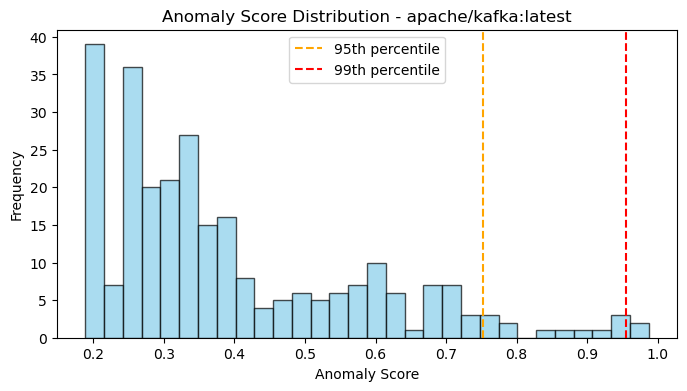


📊 Metrics for container: clickhouse/clickhouse-server:latest
Mean: 0.6702, Std: 0.1300
Min: 0.4270, Max: 0.9842
95th percentile: 0.8878 → anomaly rate ~ 5.19%
99th percentile: 0.9415 → anomaly rate ~ 1.11%


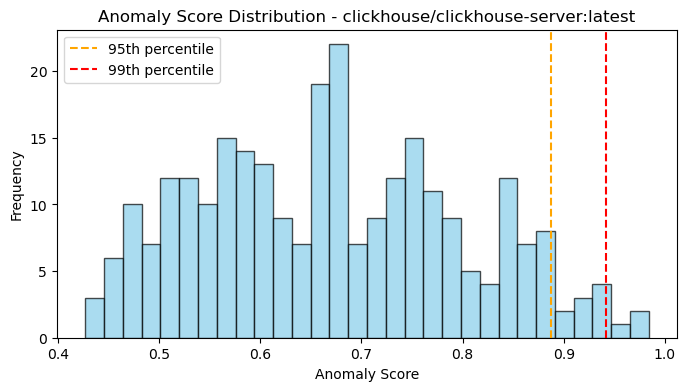


📊 Metrics for container: grafana/grafana:latest
Mean: 0.3185, Std: 0.1680
Min: 0.1560, Max: 0.9937
95th percentile: 0.6867 → anomaly rate ~ 5.06%
99th percentile: 0.8930 → anomaly rate ~ 1.05%


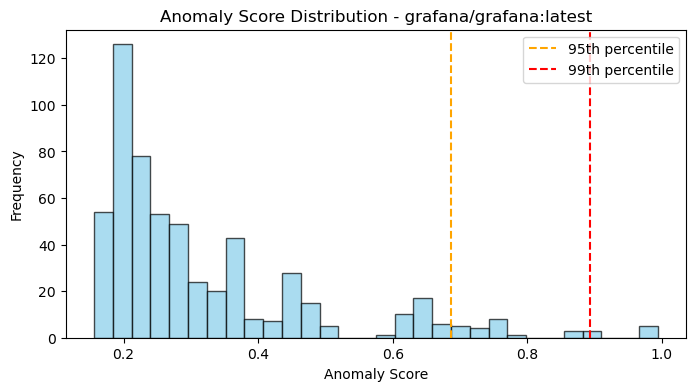


📊 Metrics for container: provectuslabs/kafka-ui:latest
Mean: 0.5228, Std: 0.1722
Min: 0.3496, Max: 0.9912
95th percentile: 0.8109 → anomaly rate ~ 5.19%
99th percentile: 0.9776 → anomaly rate ~ 1.11%


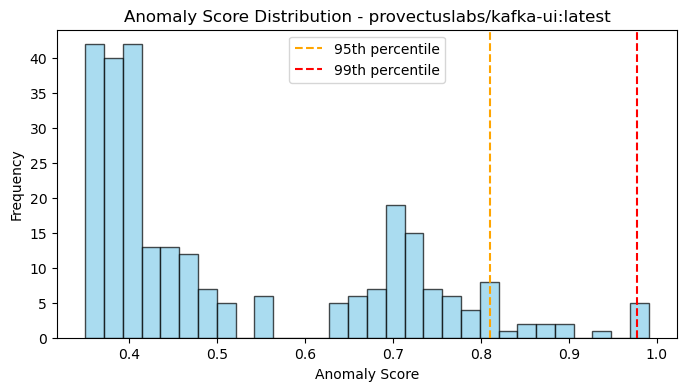

In [25]:
import matplotlib.pyplot as plt

if scores:
    results = pd.DataFrame(scores)
    for container, df_group in results.groupby("container_image"):
        if df_group.empty:
            continue
        
        # --- Metrics ---
        mean_score = df_group["anomaly_score"].mean()
        std_score = df_group["anomaly_score"].std()
        min_score = df_group["anomaly_score"].min()
        max_score = df_group["anomaly_score"].max()
        q95 = np.percentile(df_group["anomaly_score"], 95)
        q99 = np.percentile(df_group["anomaly_score"], 99)
        rate_q95 = (df_group["anomaly_score"] > q95).mean()
        rate_q99 = (df_group["anomaly_score"] > q99).mean()
    
        print(f"\n📊 Metrics for container: {container}")
        print(f"Mean: {mean_score:.4f}, Std: {std_score:.4f}")
        print(f"Min: {min_score:.4f}, Max: {max_score:.4f}")
        print(f"95th percentile: {q95:.4f} → anomaly rate ~ {rate_q95*100:.2f}%")
        print(f"99th percentile: {q99:.4f} → anomaly rate ~ {rate_q99*100:.2f}%")

        # --- Plot histogram ---
        plt.figure(figsize=(8, 4))
        plt.hist(df_group["anomaly_score"], bins=30, alpha=0.7, color="skyblue", edgecolor="black")
        plt.axvline(q95, color="orange", linestyle="--", label="95th percentile")
        plt.axvline(q99, color="red", linestyle="--", label="99th percentile")
        plt.title(f"Anomaly Score Distribution - {container}")
        plt.xlabel("Anomaly Score")
        plt.ylabel("Frequency")
        plt.legend()
        plt.show()
else:
    print("⚠️ No containers reached warm-up threshold, no metrics available yet.")